# Calculate all volumes of a regular grid, multiply by factor

The Zen of Python states that preferably there should only be one way to do it. Yet there are always so many possibilities. Tiny example: You have three arrays which define the widths of the volumes in x-/y-/z-direction of a regular 3D grid. You want to get a matrix with each voxels' volume, multiplied by a factor. Some of the many possibilities include:

- Using normal multiplication with broadcasting;
- Using `np.meshgrid` and normal multiplication;
- Using `np.dot` twice, with broadcasting;
- Using `np.tensordot` twice;
- Using `np.einsum`;
- Using `numba.njit` decorator.

I am sure there are more possibilities. In this case numba ist fastest, followed by tensordot. If the array becomes small, tensordot becomes comparably slow, and meshgrid becomes more attractive. Numba always wins.

(To be fair, the Zen of Python would apply to the implementation of each of this methods, and not to solve the problem as such.)

**=> Question: What is your approach in these situations?** Which way do you usually choose? The simplest? The fastest at any cost? The easiest to understand? The easiest to maintain?

**Note:** Before running the notebook I set:
```
export MKL_NUM_THREADS=1
export OMP_NUM_THREADS=1
```
in the terminal, to ensure that all methods only use 1 processor in order for a fair comparison.

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
%load_ext memory_profiler

## Define the functions

In [2]:
def multiply_volume_meshgrid(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    DX, DY, DZ = np.meshgrid(dx, dy, dz, indexing='ij')
    return x*DX*DY*DZ

def multiply_volume_dot(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    return np.dot(np.dot(x*dx[:, None], dy[None, :])[:, :, None], dz[None, :])

def multiply_volume_tensordot(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    return np.tensordot(np.tensordot(x*dx, dy, 0), dz, 0)

def multiply_volume_einsum(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    return np.einsum('i,j,k->ijk', x*dx, dy, dz)

def multiply_volume_broadcasting(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    return x * dx[:, None, None] * dy[None, :, None] * dz[None, None, :]

@numba.njit
def multiply_volume_numba(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    nx = len(dx)
    ny = len(dy)
    nz = len(dz)
    out = np.empty((nx, ny, nz))
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                u, v, w = dx[i], dy[j], dz[k]
                out[i, j, k] = x*u*v*w
    return out

## Define the input values

In [3]:
dx = np.random.rand(100)
dy = np.random.rand(100)
dz = np.random.rand(100)
x = 3.5

## Ensure results are the same

In [4]:
out_meshgrid = multiply_volume_meshgrid(x, dx, dy, dz)
out_dot = multiply_volume_dot(x, dx, dy, dz)
out_tensordot = multiply_volume_tensordot(x, dx, dy, dz)
out_einsum = multiply_volume_einsum(x, dx, dy, dz)
out_broadcasting = multiply_volume_broadcasting(x, dx, dy, dz)
out_numba = multiply_volume_numba(x, dx, dy, dz)

print('All results are numerically the same: ',
      np.all([np.allclose(out_meshgrid, out_dot),
              np.allclose(out_meshgrid, out_tensordot),
              np.allclose(out_meshgrid, out_einsum),
              np.allclose(out_meshgrid, out_broadcasting),
              np.allclose(out_meshgrid, out_numba)]))

All results are numerically the same:  True


## Runtime comparison

In [5]:
print('np.meshgrid  :: ', end='')
%timeit multiply_volume_meshgrid(x, dx, dy, dz)
print('np.dot       :: ', end='')
%timeit multiply_volume_dot(x, dx, dy, dz)
print('np.einsum    :: ', end='')
%timeit multiply_volume_einsum(x, dx, dy, dz)
print('broadcasting :: ', end='')
%timeit multiply_volume_broadcasting(x, dx, dy, dz)
print('np.tensordot :: ', end='')
%timeit multiply_volume_tensordot(x, dx, dy, dz)
print('numba.njit   :: ', end='')
%timeit multiply_volume_numba(x, dx, dy, dz)

np.meshgrid  :: 16.2 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
np.dot       :: 8.18 ms ± 45.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
np.einsum    :: 3.54 ms ± 40.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
broadcasting :: 1.9 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
np.tensordot :: 1.71 ms ± 65.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
numba.njit   :: 810 µs ± 52.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Memory comparison

In [6]:
print('np.meshgrid  :: ', end='')
%memit multiply_volume_meshgrid(x, dx, dy, dz)
print('np.dot       :: ', end='')
%memit multiply_volume_dot(x, dx, dy, dz)
print('np.einsum    :: ', end='')
%memit multiply_volume_einsum(x, dx, dy, dz)
print('broadcasting :: ', end='')
%memit multiply_volume_broadcasting(x, dx, dy, dz)
print('np.tensordot :: ', end='')
%memit multiply_volume_tensordot(x, dx, dy, dz)
print('numba.njit   :: ', end='')
%memit multiply_volume_numba(x, dx, dy, dz)

np.meshgrid  :: peak memory: 197.78 MiB, increment: 22.94 MiB
np.dot       :: peak memory: 174.95 MiB, increment: 7.50 MiB
np.einsum    :: peak memory: 174.95 MiB, increment: 0.00 MiB
broadcasting :: peak memory: 175.13 MiB, increment: 0.19 MiB
np.tensordot :: peak memory: 175.14 MiB, increment: 0.00 MiB
numba.njit   :: peak memory: 175.14 MiB, increment: 0.00 MiB


## Extended runtime comparison

In [7]:
nx = [1, 10, 10, 10, 100, 100, 100, 1000]
ny = [1, 1, 10, 10, 10, 100, 100, 100]
nz = [1, 1, 1, 10, 10, 10, 100, 100]
nxyz = np.array(nx)*np.array(ny)*np.array(nz)
s = 3.5

out = {'mg': [], 'dt': [], 'es': [], 'td': [], 'bc': [], 'nb': []}
for i in range(len(nx)):
    dx = np.random.rand(nx[i])
    dy = np.random.rand(ny[i])
    dz = np.random.rand(nz[i])
    n = nxyz[i]
    print('   ', n, '; ', end='')
    out_mg = %timeit -o -q multiply_volume_meshgrid(x, dx, dy, dz)          
    out_dt = %timeit -o -q multiply_volume_dot(x, dx, dy, dz)
    out_es = %timeit -o -q multiply_volume_einsum(x, dx, dy, dz)
    out_td = %timeit -o -q multiply_volume_tensordot(x, dx, dy, dz)
    out_bc = %timeit -o -q multiply_volume_broadcasting(x, dx, dy, dz)
    out_nb = %timeit -o -q multiply_volume_numba(x, dx, dy, dz)
    # Store in ms
    out['mg'].append(1000*out_mg.best)
    out['dt'].append(1000*out_dt.best)
    out['es'].append(1000*out_es.best)
    out['td'].append(1000*out_td.best)
    out['bc'].append(1000*out_bc.best)
    out['nb'].append(1000*out_nb.best)

    1 ;     10 ;     100 ;     1000 ;     10000 ;     100000 ;     1000000 ;     10000000 ; 

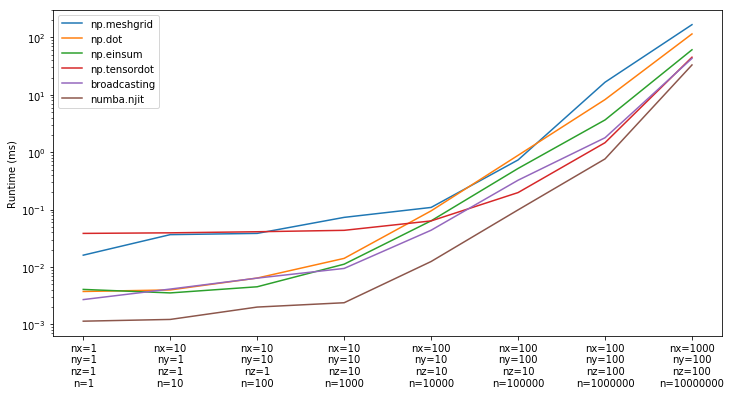

In [8]:
plt.figure(figsize=(12,6))
plt.plot(out['mg'], label='np.meshgrid')
plt.plot(out['dt'], label='np.dot')
plt.plot(out['es'], label='np.einsum')
plt.plot(out['td'], label='np.tensordot')
plt.plot(out['bc'], label='broadcasting')
plt.plot(out['nb'], label='numba.njit')
plt.yscale('log')
plt.legend()

label = []
for i in range(len(nx)):
    label.append('nx='+str(nx[i])+'\nny='+str(ny[i])+'\nnz='+str(nz[i])+'\nn='+str(nxyz[i])+'')
plt.xticks(np.arange(len(nx)), label)
plt.ylabel('Runtime (ms)')
plt.show()